In [96]:
import torch
from torch import Tensor
from torch_geometric.data import Data
from typing import TypeAlias

# Cochain is just a tensor over nodes (k=0) or edges (k=1)
Cochain: TypeAlias = Tensor

# PyG's Data class serves as our graph representation
Graph = Data


def coboundary_adjoint(c: Cochain, g: Graph) -> Cochain:
    """
    c: [..., M]
    return: [..., N]
    """
    batch_shape = c.shape[:-1]
    num_nodes = g.num_nodes
    senders, receivers = g.edge_index

    res = torch.zeros((*batch_shape, num_nodes))
    res.index_add_(-1, receivers, c, alpha=1)
    res.index_add_(-1, senders, c, alpha=-1)
    return res


def coboundary(c: Cochain, g: Graph) -> Cochain:
    """
    c: [..., N]
    return: [..., M]
    """
    senders, receivers = g.edge_index
    return c[..., receivers] - c[..., senders]


def codegree(g: Graph) -> Cochain:
    """
    return: [..., N]
    """
    num_nodes = g.num_nodes
    senders = g.edge_index[0]
    deg = torch.zeros(num_nodes, device=senders.device)
    deg.index_add_(0, senders, torch.ones_like(senders, dtype=torch.float))
    return deg


def codegree_at_nonnegative(c: Cochain, g: Graph) -> Cochain:
    """
    c: [..., M]
    return: [..., N]
    """
    num_nodes, batch_shape = g.num_nodes, c.shape[:-1]
    senders = g.edge_index[0]

    senders_at_nonneg = senders[c >= 0]
    deg = torch.zeros((*batch_shape, num_nodes), device=senders_at_nonneg.device, dtype=senders_at_nonneg.dtype)
    deg.index_add_(0, senders_at_nonneg, torch.ones_like(senders_at_nonneg))
    return deg


def lift(p: Cochain, g: Graph) -> Cochain:
    """
    p: [..., N]
    return: [..., M]
    """
    senders = g.edge_index[0]
    return p[..., senders]


def mass_preserving_lift(p: Cochain, g: Graph) -> Cochain:
    """
    p: [..., N]
    return: [..., M]
    """
    senders = g.edge_index[0]
    cdeg = codegree(g)
    
    return p[..., senders] / cdeg[senders]


def flow_field(p: Cochain, nu: Cochain, g: Graph) -> Cochain:
    """
    p: [..., N]
    nu: [..., M]
    return: [..., M]
    """
    return mass_preserving_lift(p, g) * nu


def continuity_equation_euler_step(p: Cochain, nu: Cochain, dt: float, g: Graph) -> Cochain:
    """
    p: [..., N]
    nu: [..., M]

    return: [..., N]
    """
    div = coboundary_adjoint(flow_field(p, nu, g), g)
    return p + dt * div


In [92]:
import torch
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
from typing import Callable, Protocol, Tuple


# --- Continuity Equation Simulation ---


def postprocess(p: Cochain) -> Cochain:
    """
    Due to approximation, sometimes the probability distiribution might be slightly negative or mass may be not equal to 1.
    """
    p = torch.clamp(p, min=0.0)
    p = p / torch.sum(p, dim=-1, keepdim=True) 
    return p



def simulate_continuity_equation(
    p: Cochain, nu_fn: Callable[[float], Cochain], g: Graph, num_steps: int = 1000
) -> Cochain:
    """
    p: [..., N]
    nu_fn: [T] -> [T, ..., N]
    return: [T, ..., N]
    """
    dt = 1.0 / num_steps
    ts = torch.linspace(0.0, 1.0, steps=num_steps + 1)[:-1]
    nus = nu_fn(ts)

    ps = [p]
    for nu in nus:
        p = continuity_equation_euler_step(p, nu, dt, g)
        p = postprocess(p)
        ps.append(p)
    return torch.vstack(ps)


# --- Biharmonic Distance ---

def graph_laplacian(g: Graph) -> Tensor:
    """
    Computes symmetric combinatorial Laplacian L = D - A
    """
    edge_index = g.edge_index
    num_nodes = g.num_nodes
    A = to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0)
    D = torch.diag(A.sum(dim=1))
    return D - A


def laplacian_eigenpairs(g: Graph) -> Tuple[Tensor, Tensor]:
    """
    Returns eigenvalues and eigenvectors of the Laplacian.
    """
    L = graph_laplacian(g)
    eigvals, eigvecs = torch.linalg.eigh(L)
    return eigvals, eigvecs


class Premetric(Protocol):
    def distance(self, x: int, y: int) -> float:
        ...

    def __call__(self, x: int, y: int) -> float:
        ...

    def distance_to(self, tau: int) -> Cochain:
        ...


class BiharmonicDistance(Premetric):
    def __init__(self, g: Graph):
        self.graph = g
        eigvals, eigvecs = laplacian_eigenpairs(g)
        self.eigvals = eigvals[1:]  # [K]
        self.eigvecs = eigvecs[:, 1:] # [N, K] <- eigenvectors as columns

    def distance(self, x: Tensor, y: Tensor) -> Tensor:
        phi_x = self.eigvecs[x]
        phi_y = self.eigvecs[y]
        diff_sq = (phi_x - phi_y).pow(2)
        return float((diff_sq / self.eigvals.pow(2)).sum())

    def distance_to(self, tau: Tensor) -> Cochain:
        """
        tau: [...]
        return: [..., N]
        """
        phi_tau = self.eigvecs[tau] # [..., K] # eigenvectors evaluated at tau

        diff_sq = torch.square(self.eigvecs - phi_tau[..., None, :]) # [N, K] - [..., 1, K]
        w = torch.square(self.eigvals) # [K]
        return torch.sum(diff_sq / w, dim=-1)
        # diff_sq = (self.eigvecs - phi_tau).pow(2)
        # return (diff_sq / self.eigvals.pow(2)).sum(dim=1)

In [107]:
import torch
from torch import Tensor
from typing import Callable
import math
from functorch import jacfwd


def linear_schedule(t: Tensor) -> Tensor:
    """
    t: [...]
    return: [...]
    """
    return 1.0 - t


def conditional_flow_field(tau: int, rho: Premetric, t: float | Tensor, g: Graph) -> Cochain:
    """
    tau: [...], 
    t: [T],
    return: [T, ..., N]
    """
    t = torch.as_tensor(t)

    rho_tau = rho.distance_to(tau) # [..., N]
    
    # dlogkappa = jacfwd(lambda x: torch.log(linear_schedule(x)), t)
    delta_rho_tau = coboundary(rho_tau, g) # [..., M]

    # Take only positive components so that the non-negativity of mass is preserved
    codeg = codegree(g) # [N]
    codeg_at_nonnegative = codegree_at_nonnegative(-delta_rho_tau, g) # [..., N]
    Lrho_tau_scaled = lift(codeg / codeg_at_nonnegative * rho_tau, g) # [..., M]

    res = torch.where(
        (delta_rho_tau <= 0) & (lift(rho_tau, g) > 0), # [..., M] & [..., M]
        Lrho_tau_scaled / delta_rho_tau, # [..., M]
        torch.zeros_like(delta_rho_tau)
    ) # [..., M]


    # Scale to match schedule
    dlogkappa = -1.0 / (1.0 - t)
    if t.ndim == 0:
        return dlogkappa * res
    else:
        return torch.einsum('t, ...m -> t...m', dlogkappa, res)


def uniform_distribution(g: Graph) -> Cochain:
    """
    return: [N]
    """
    num_nodes = g.num_nodes
    return torch.ones(num_nodes) / num_nodes

In [76]:
def interpolate(xp: Tensor, yp: Tensor, x: Tensor) -> Tensor:
    """
    Linear interpolation of 1D function values (yp) at query locations x.
    xp: [N], yp: [N, D], x: [M]
    Returns: [M, D]
    """
    idx = torch.searchsorted(xp, x, right=True)
    idx = torch.clamp(idx, 1, len(xp) - 1)
    idx0 = idx - 1
    idx1 = idx

    x0 = xp[idx0]
    x1 = xp[idx1]
    y0 = yp[idx0]
    y1 = yp[idx1]

    w = (x - x0) / (x1 - x0 + 1e-8)
    return (1 - w[:, None]) * y0 + w[:, None] * y1


def conditional_flow_matching_loss(
    tau: int,
    rho: Premetric,
    p0: Cochain,
    model: Callable[[float], Cochain],
    g: Graph,
    *,
    num_t_samples: int,
    num_steps: int,
    device: torch.device,
) -> Tensor:
    # 1. Simulate p_t over [0, 1]
    ts = torch.linspace(0, 1, num_steps + 1, device=device)[:-1]
    pts = simulate_continuity_equation(
        p0, 
        lambda t: conditional_flow_field(tau, rho, t, g),
        g, 
        num_steps,
    )
    # print(torch.min(pts), torch.max(pts))

    # 2. Sample t values
    t_samples = torch.rand(num_t_samples, device=device)

    # 3. Interpolate p_t at t samples
    pts_samples = interpolate(ts, pts, t_samples)  # [num_t_samples, num_nodes]
    Lpts_samples = mass_preserving_lift(pts_samples, g)  # [num_t_samples, num_edges]
    # Lpts_samples = torch.stack([
    #     mass_preserving_lift(pt, g) for pt in pts_samples
    # ])  # [num_t_samples, num_edges]

    # 4. Compute target flow field and model predictions
    conditional_targets = torch.stack([
        conditional_flow_field(tau, rho, t.item(), g) for t in t_samples
    ])  # [num_t_samples, num_edges]

    model_preds = torch.stack([
        model(t.item()) for t in t_samples
    ])  # [num_t_samples, num_edges]

    # 5. Weighted L2 loss
    sq_diff = (model_preds - conditional_targets) ** 2 * Lpts_samples

    loss = sq_diff.sum(dim=1).mean()
    return loss


def conditional_flow_matching_loss_deterministic(
    tau: int,
    rho: Premetric,
    p0: Cochain,
    model: Callable[[float], Cochain],
    g: Graph,
    *,
    num_t_samples: int,
    num_steps: int,
    device: torch.device,
    cache = None,
) -> Tensor:
    # 1. Simulate p_t over [0, 1]
    ts = torch.linspace(0, 1, num_steps + 1, device=device)[:-1]
    if cache is None:
        pts = simulate_continuity_equation(
            p0, 
            lambda t: conditional_flow_field(tau, rho, t, g),
            g, 
            num_steps,
        )[:-1]

        # 2. Sample t values
        indices = torch.randint(low=0, high=pts.size(0), size=(num_t_samples,), dtype=torch.long)
        ts_samples = ts[indices]  # [num_t_samples, num_nodes]
        pts_samples = pts[indices]  # [num_t_samples, num_nodes]

        Lpts_samples = mass_preserving_lift(pts_samples, g)

        # 4. Compute target flow field and model predictions
        conditional_targets = torch.stack([
            conditional_flow_field(tau, rho, t.item(), g) for t in ts_samples
        ])  # [num_t_samples, num_edges]

    else:
        Lpts, conditional_targets = cache[tau.item()]

        indices = torch.randint(low=0, high=Lpts.size(0), size=(num_t_samples,), dtype=torch.long)
        ts_samples = ts[indices]  # [num_t_samples, num_nodes]
        Lpts_samples = Lpts[indices]  # [num_t_samples, num_edges]
        conditional_targets = conditional_targets[indices]  # [num_t_samples, num_edges]



    # model_preds = model(ts_samples)
    # model_preds = model(ts_samples)
    model_preds = torch.stack([
        model(t.item()) for t in ts
    ])  # [num_t_samples, num_edges]

    # 5. Weighted L2 loss
    sq_diff = (model_preds - conditional_targets) ** 2 * Lpts_samples

    loss = sq_diff.sum(dim=1).mean()
    return loss

In [77]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv

class TimeEncoder(nn.Module):
    def __init__(self, time_dim: int):
        super().__init__()
        self.freqs = nn.Parameter(torch.randn(time_dim), requires_grad=True)
        self.proj = nn.Linear(time_dim * 2, time_dim)  # Fix: match input shape

    def forward(self, t: float, num_nodes: int) -> torch.Tensor:
        t_tensor = torch.full((num_nodes, 1), t, dtype=torch.float32, device=self.freqs.device)
        sin = torch.sin(self.freqs * t_tensor)
        cos = torch.cos(self.freqs * t_tensor)
        sin_cos = torch.cat([sin, cos], dim=-1)  # [num_nodes, 2 * time_dim]
        return self.proj(sin_cos)  # [num_nodes, time_dim]
    

class TimeConditionedFlowGNN(nn.Module):
    def __init__(self, node_input_dim: int, time_dim: int, hidden_dim: int, heads: int = 4):
        super().__init__()
        self.time_encoder = TimeEncoder(time_dim)
        self.gat = GATConv(node_input_dim + time_dim, hidden_dim, heads=heads, concat=True)
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_dim * heads * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()  # non-negative output
        )

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, t: float) -> torch.Tensor:
        t_emb = self.time_encoder(t, x.size(0))  # [num_nodes, time_dim]
        x_t = torch.cat([x, t_emb], dim=-1)
        h = self.gat(x_t, edge_index)  # [num_nodes, hidden_dim * heads]

        i, j = edge_index  # edge_index: [2, num_edges]
        edge_inputs = torch.cat([h[i], h[j]], dim=-1)
        return self.edge_mlp(edge_inputs).squeeze(-1)  # [num_edges]


In [53]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class FlowGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.gnn = GCNConv(in_dim, hidden_dim)
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()  # ensure non-negative output
        )

    def forward(self, x, edge_index):
        h = self.gnn(x, edge_index)
        # Create edge features by concatenating h_i and h_j
        i, j = edge_index
        edge_feat = torch.cat([h[i], h[j]], dim=-1)
        return self.edge_mlp(edge_feat).squeeze(-1)


def add_onehot_encoding(data: Data) -> Data:
    data.x = torch.eye(data.num_nodes)
    return data

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def fourier_encode(t, num_freqs=8):
    freqs = 2 ** torch.arange(0, num_freqs).float() * torch.pi
    freqs = freqs.to(t.device)
    ts = t.unsqueeze(-1)  # shape: [B, 1]
    return torch.cat([ts, torch.sin(freqs * ts), torch.cos(freqs * ts)], dim=-1)  # [B, 1 + 2 * num_freqs]

class TimeToEdgeFlowMLP(nn.Module):
    def __init__(self, hidden_dim: int, num_edges: int, num_freqs: int = 16):
        super().__init__()
        self.num_freqs = num_freqs
        input_dim = 1 + 2 * num_freqs  # raw t + sin/cos Fourier features

        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden1 = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim + input_dim, num_edges)

    def forward(self, t: float | torch.Tensor) -> torch.Tensor:
        if isinstance(t, float):
            t = torch.tensor([t], dtype=torch.float32)
        if t.ndim == 0:
            t = t.view(1)
        if t.ndim == 1:
            t = t.unsqueeze(-1)  # shape: [B, 1]

        # Fourier encode time + keep raw t
        t_feat = fourier_encode(t.squeeze(-1), num_freqs=self.num_freqs)  # shape: [B, 1 + 2 * num_freqs]

        h0 = F.relu(self.input(t_feat))
        h0t = torch.cat([h0, t_feat], dim=-1)
        h1 = F.relu(self.hidden1(h0t) + h0)
        h1t = torch.cat([h1, t_feat], dim=-1)
        h2 = F.relu(self.hidden2(h1t) + h1)
        h2t = torch.cat([h2, t_feat], dim=-1)

        out = F.softplus(self.output(h2t))  # non-negative output
        return out


In [55]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize


def build_circle_graph(n: int) -> Data:
    edge_index = torch.tensor(
        [[i for i in range(n)] + [(i + 1) % n for i in range(n)],
         [(i + 1) % n for i in range(n)] + [i for i in range(n)]],
        dtype=torch.long
    )
    x = torch.ones((n, 1), dtype=torch.float32)
    edge_attr = torch.ones((edge_index.shape[1], 1), dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


def build_karate_graph() -> Data:
    G = nx.karate_club_graph()
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)  # Make undirected

    num_nodes = G.number_of_nodes()
    x = torch.ones((num_nodes, 1), dtype=torch.float32)
    edge_attr = torch.ones((edge_index.shape[1], 1), dtype=torch.float32)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


def build_example_graph() -> Data:
    edges = torch.tensor([
        [0, 1],
        [1, 2],
        [2, 0],
        [2, 3],
        [3, 4]
    ], dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edges, edges[[1, 0]]], dim=1)  # Make undirected

    num_nodes = 5
    x = torch.ones((num_nodes, 1), dtype=torch.float32)
    edge_attr = torch.ones((edge_index.shape[1], 1), dtype=torch.float32)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


def plot_graph(g: Data):
    G = nx.Graph()
    G.add_nodes_from(range(g.num_nodes))
    edges = g.edge_index.cpu().numpy().T
    G.add_edges_from([tuple(edge) for edge in edges])
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=600)
    plt.title("Example Graph")
    plt.show()


def plot_laplacian_eigenvectors(g: Graph, num_vecs: int = 4):
    """
    Plot the first few Laplacian eigenvectors (excluding the trivial one).
    Each eigenvector is shown as node colors.
    """
    eigvals, eigvecs = laplacian_eigenpairs(g)

    G = nx.Graph()
    for i in range(g.num_nodes):
        G.add_node(i)
    for s, r in zip(g.edge_index[0], g.edge_index[1]):
        G.add_edge(int(s), int(r))

    pos = nx.spring_layout(G, seed=42)

    fig, axs = plt.subplots(1, num_vecs, figsize=(4 * num_vecs, 4))
    axs = axs if isinstance(axs, (list, np.ndarray)) else [axs]

    for i in range(num_vecs):
        eigvec = eigvecs[:, i]
        ax = axs[i]
        nodes = nx.draw_networkx_nodes(
            G, pos, node_color=eigvec, cmap="coolwarm", ax=ax, vmin=-1, vmax=1
        )
        nx.draw_networkx_edges(G, pos, ax=ax)
        nx.draw_networkx_labels(G, pos, ax=ax)
        ax.set_title(f"Eigenvector {i}\nλ = {eigvals[i]:.2f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def plot_biharmonic_distance(g: Data, source_node: int):
    from scipy.sparse import coo_matrix
    from scipy.sparse.linalg import eigsh

    num_nodes = g.num_nodes
    edges = g.edge_index.cpu().numpy()
    row, col = edges
    data = np.ones(row.shape)
    A = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes))
    D = np.diag(A.sum(axis=1).A1)
    L = D - A.toarray()

    eigvals, eigvecs = eigsh(L, k=num_nodes - 1, which='SM')
    eigvals, eigvecs = eigvals[1:], eigvecs[:, 1:]

    phi_x = eigvecs[source_node]
    diff = eigvecs - phi_x
    distances = (diff**2 / eigvals**2).sum(axis=1)

    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(zip(row, col))
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(6, 5))
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=distances,
        cmap="viridis",
        node_size=500
    )
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.colorbar(nodes, label=f"Biharmonic distance from node {source_node}")
    plt.title(f"Biharmonic Distance from Node {source_node}")
    plt.axis("off")
    plt.show()


In [56]:
graph = build_circle_graph(20)
graph = add_onehot_encoding(graph)

probs = torch.zeros(20)
probs[[0, 5, 10, 15]] = 0.25
dist = torch.distributions.Categorical(probs=probs)
taus = dist.sample((1024,))

# model = FlowGNN(in_dim=graph.num_nodes, hidden_dim=16)
num_edges = graph.edge_index.shape[1]
model = TimeToEdgeFlowMLP(hidden_dim=64, num_edges=num_edges).to('cpu')


# model = TimeConditionedFlowGNN(
#     node_input_dim=graph.num_nodes,
#     time_dim=16,
#     hidden_dim=16
# )

In [43]:
num_epochs = 500
batch_size = 64

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
rho = BiharmonicDistance(graph)

losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    taus = taus[torch.randperm(len(taus))]
    for i, batch_taus in enumerate(torch.chunk(taus, batch_size)):
        batch_loss = 0
        optimizer.zero_grad()
        for tau in batch_taus:
            # rho.conditional_distance(tau)
            loss = conditional_flow_matching_loss_deterministic(
                tau=tau,
                rho=rho,
                p0=uniform_distribution(graph),
                model=lambda t: model(t),
                # model=lambda t: model(graph.x, graph.edge_index, t),
                g=graph,
                num_t_samples=1000,
                num_steps=1000,
                device='cpu'
            )
            # print(loss)
            batch_loss += loss
        batch_loss = batch_loss / batch_size
        print(batch_loss, f"{i}/{len(taus) // batch_size}")
        batch_loss.backward()
        optimizer.step()
        epoch_loss += batch_loss.item()
    epoch_loss = epoch_loss / (len(taus) // batch_size)
    losses.append(epoch_loss.item())
    print(f"Epoch {epoch}: Loss = {epoch_loss.item():.4f}")


plt.plot(losses)


tensor(1097.7983, grad_fn=<DivBackward0>) 0/16


KeyboardInterrupt: 

In [17]:
simulate_continuity_equation_trajectory(
    p0=uniform_distribution(graph),
    nu_fn=lambda t: model(t)[0],
    g=graph,
    num_steps=1000
)[-1]

tensor([0.1840, 0.0318, 0.0244, 0.0262, 0.0353, 0.1016, 0.0259, 0.0205, 0.0219,
        0.0318, 0.1678, 0.0332, 0.0233, 0.0216, 0.0267, 0.0997, 0.0337, 0.0257,
        0.0265, 0.0381], grad_fn=<SelectBackward0>)

/tmp/ipykernel_2566748/2854455320.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  pos_tensor = torch.tensor(pos, dtype=torch.float32)


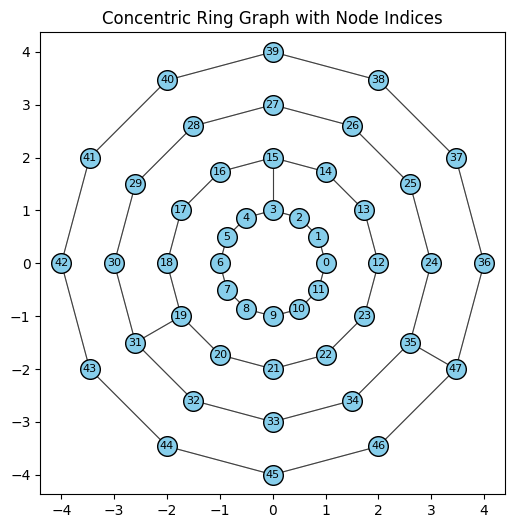

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data

def build_centered_bridge_concentric_ring_graph(num_rings=4, nodes_per_ring=12, radius_step=1.0, num_bridges=3) -> Data:
    pos = []
    edge_index = []
    ring_node_indices = []
    node_offset = 0

    for r in range(num_rings):
        radius = (r + 1) * radius_step
        theta = np.linspace(0, 2 * np.pi, nodes_per_ring, endpoint=False)
        xs = radius * np.cos(theta)
        ys = radius * np.sin(theta)
        ring_pos = np.stack([xs, ys], axis=1)

        pos.extend(ring_pos)
        ring_node_indices.append(np.arange(node_offset, node_offset + nodes_per_ring))

        # Intra-ring cycle connections
        for i in range(nodes_per_ring):
            a = node_offset + i
            b = node_offset + (i + 1) % nodes_per_ring
            edge_index.extend([[a, b], [b, a]])

        node_offset += nodes_per_ring

    # Inter-ring bridges: spaced evenly around center
    d = np.pi / 2
    bridge_angles = np.linspace(0 + d, 2 * np.pi + d, num_bridges, endpoint=False)
    for r in range(num_bridges):  # r = ring index for lower ring
        lower_ring = ring_node_indices[r]
        upper_ring = ring_node_indices[r + 1]

        theta = np.linspace(0, 2 * np.pi, nodes_per_ring, endpoint=False)

        # Find closest nodes in both rings to the bridge angle
        angle = bridge_angles[r]
        lower_idx = np.argmin(np.abs(((theta - angle + np.pi) % (2 * np.pi)) - np.pi))
        upper_idx = np.argmin(np.abs(((theta - angle + np.pi) % (2 * np.pi)) - np.pi))

        a = lower_ring[lower_idx]
        b = upper_ring[upper_idx]
        edge_index.extend([[a, b], [b, a]])

    pos_tensor = torch.tensor(pos, dtype=torch.float32)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.eye(len(pos))  # one-hot node features

    return Data(x=x, pos=pos_tensor, edge_index=edge_index_tensor)


# === Visualize with node labels
graph = build_centered_bridge_concentric_ring_graph(num_rings=4, nodes_per_ring=12, num_bridges=3)
pos = graph.pos.numpy()
plt.figure(figsize=(6, 6))
for i, j in graph.edge_index.t():
    plt.plot([pos[i][0], pos[j][0]], [pos[i][1], pos[j][1]], 'k-', linewidth=0.8, alpha=0.5, zorder=1)
plt.scatter(pos[:, 0], pos[:, 1], c='skyblue', s=200, edgecolors='black')

# Add node labels
for idx, (x, y) in enumerate(pos):
    plt.text(x, y, str(idx), fontsize=8, ha='center', va='center', color='black')

plt.axis('equal')
plt.title("Concentric Ring Graph with Node Indices")
plt.show()


In [13]:
num_edges = graph.edge_index.shape[1]
model = TimeToEdgeFlowMLP(hidden_dim=64, num_edges=num_edges).to('cpu')


import torch
from torch.distributions import Categorical

# Unnormalized logits or probabilities for 5 categories
probs = torch.zeros(graph.num_nodes)
probs[7] = 0.25
probs[11] = 0.25
probs[19:24] = 0.1

# Create categorical distribution
dist = Categorical(probs=probs)


p0 = torch.zeros(graph.num_nodes)
p0[36:48] = 1/12
p0 = p0 / p0.sum()

p0 = uniform_distribution(graph)

In [15]:
cache = {
    tau: (mass_preserving_lift(simulate_continuity_equation_trajectory(
        p0, 
        lambda t: conditional_flow_field(tau, rho, t, graph),
        graph, 
        num_steps=1000,
    )[:-1], graph), 
    torch.vstack([
        conditional_flow_field(tau, rho, t.item(), graph) for t in torch.linspace(0, 1, 1001)[:-1]
    ])
    )
    for tau in [7, 11, 19, 20, 21, 22, 23]
}

Epoch 0: Loss = 1592.2936
Epoch 1: Loss = 1395.6442
Epoch 2: Loss = 1575.1456
Epoch 3: Loss = 1273.0302
Epoch 4: Loss = 1442.0613
Epoch 5: Loss = 1255.6310
Epoch 6: Loss = 1854.9183
Epoch 7: Loss = 1522.7084
Epoch 8: Loss = 2988.3305
Epoch 9: Loss = 1000.7391
Epoch 10: Loss = 1883.7554
Epoch 11: Loss = 1168.4152
Epoch 12: Loss = 2918.1776
Epoch 13: Loss = 1739.7006
Epoch 14: Loss = 2127.1537
Epoch 15: Loss = 1761.6453
Epoch 16: Loss = 1478.7976
Epoch 17: Loss = 1338.1705
Epoch 18: Loss = 1910.3530
Epoch 19: Loss = 1848.7199
Epoch 20: Loss = 2395.6887
Epoch 21: Loss = 1354.7742
Epoch 22: Loss = 1962.1064
Epoch 23: Loss = 2119.7204
Epoch 24: Loss = 2109.4385
Epoch 25: Loss = 2232.6244
Epoch 26: Loss = 2437.4583
Epoch 27: Loss = 1830.3454
Epoch 28: Loss = 1415.5128
Epoch 29: Loss = 1870.2434
Epoch 30: Loss = 1336.4140
Epoch 31: Loss = 1457.6825
Epoch 32: Loss = 1617.7093
Epoch 33: Loss = 2531.4057
Epoch 34: Loss = 1221.7009
Epoch 35: Loss = 1529.2616
Epoch 36: Loss = 1623.3044
Epoch 37: L

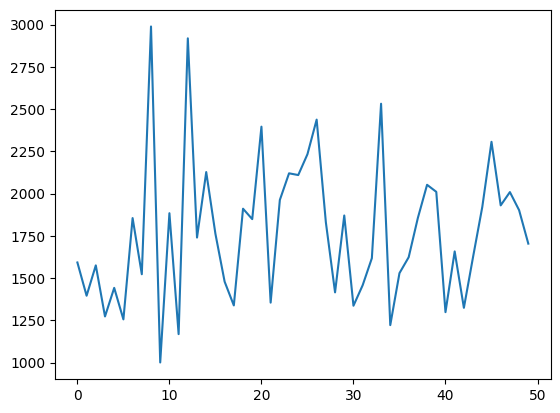

In [16]:
num_epochs = 50


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
rho = BiharmonicDistance(graph)




losses = []
for epoch in range(num_epochs):
    taus = dist.sample((128,))
    total_loss = 0
    for batch in torch.chunk(taus, 32):
        batch_loss = 0
        optimizer.zero_grad()
        for tau in batch:
            loss = conditional_flow_matching_loss_deterministic(
                tau=tau,
                rho=rho,
                p0=p0,
                # p0=uniform_distribution(graph),
                model=lambda t: model(t),
                # model=lambda t: model(graph.x, graph.edge_index, t),
                g=graph,
                num_t_samples=16,
                num_steps=1000,
                device='cpu',
                cache=cache,
            )
            # loss.backward()
            # optimizer.step()
            batch_loss += loss
        batch_loss /= len(batch)
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        
    total_loss /= (128 // 32)
    print(f"Epoch {epoch}: Loss = {total_loss:.4f}")
    losses.append(total_loss)

plt.plot(losses)


In [17]:
final = simulate_continuity_equation_trajectory(
    p0=uniform_distribution(graph),
    nu_fn=lambda t: model(t)[0],
    g=graph,
    num_steps=1000
)[-1]
final[final.argsort(descending=True)[:10]], final.argsort(descending=True)[:10]

(tensor([0.1061, 0.0918, 0.0808, 0.0524, 0.0520, 0.0494, 0.0482, 0.0472, 0.0441,
         0.0423], grad_fn=<IndexBackward0>),
 tensor([11,  7, 18, 22, 23, 17, 21, 10, 15,  8]))

In [110]:


import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm
from torch_geometric.data import Data
import torch


def plot_edge_flow(g: Data, flow: torch.Tensor, title: str = "Flow Field"):
    """
    Plots edge orientations and flow values on an undirected graph.
    Arrows go from sender to receiver. Color represents the flow value, centered at 0.
    """
    G = nx.Graph()
    edge_index = g.edge_index.cpu().numpy()
    for i in range(g.num_nodes):
        G.add_node(i)
    for s, r in edge_index.T:
        G.add_edge(int(s), int(r))

    pos = nx.spring_layout(G, seed=42)
    flow_vals = flow.detach().cpu().numpy()

    vmin, vmax = flow_vals.min(), flow_vals.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("viridis")
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    fig, ax = plt.subplots()
    ax.set_title(title)
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=400, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    for i, (s, r) in enumerate(edge_index.T):
        if abs(flow_vals[i]) == 0.0:
            continue
        start, end = pos[int(s)], pos[int(r)]
        vec = np.array(end) - np.array(start)
        color = cmap(norm(flow_vals[i]))
        width = 0.5 + 2.5 * abs(flow_vals[i]) / (abs(flow_vals).max() + 1e-8)
        ax.arrow(start[0], start[1], vec[0]*0.85, vec[1]*0.85,
                 head_width=0.03, head_length=0.05, length_includes_head=True,
                 color=color, alpha=0.8, linewidth=width)

    plt.colorbar(sm, ax=ax, label="Flow value (centered at 0)")
    ax.axis("off")
    plt.show()


def plot_0chain(g: Data, cochain: torch.Tensor, title: str = "0-Cochain"):
    """
    Plots a 0-cochain as node colors on the graph.
    """
    values = cochain.detach().cpu().numpy()
    G = nx.Graph()
    for i in range(g.num_nodes):
        G.add_node(i)
    for s, r in g.edge_index.cpu().T:
        G.add_edge(int(s), int(r))

    pos = nx.spring_layout(G, seed=42)
    vmin, vmax = values.min(), values.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("coolwarm")

    fig, ax = plt.subplots()
    ax.set_title(title)
    nodes = nx.draw_networkx_nodes(G, pos, node_color=values, cmap=cmap,
                                   node_size=400, ax=ax, vmin=vmin, vmax=vmax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)

    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Value")
    ax.axis("off")
    plt.show()


def plot_1chain(g: Data, cochain: torch.Tensor, title: str = "1-Cochain"):
    """
    Plots a 1-cochain as colored arrows along graph edges (from sender to receiver).
    """
    values = cochain.detach().cpu().numpy()
    edge_index = g.edge_index.cpu().numpy()
    G = nx.Graph()
    for i in range(g.num_nodes):
        G.add_node(i)
    for s, r in edge_index.T:
        G.add_edge(int(s), int(r))

    pos = nx.spring_layout(G, seed=42)
    vmin, vmax = values.min(), values.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("coolwarm")

    fig, ax = plt.subplots()
    ax.set_title(title)
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=400, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    for i, (s, r) in enumerate(edge_index.T):
        start, end = pos[int(s)], pos[int(r)]
        vec = np.array(end) - np.array(start)
        color = cmap(norm(values[i]))
        width = 0.5 + 2.5 * abs(values[i]) / (abs(values).max() + 1e-8)
        ax.arrow(start[0], start[1], vec[0]*0.85, vec[1]*0.85,
                 head_width=0.03, head_length=0.05, length_includes_head=True,
                 color=color, alpha=0.8, linewidth=width)

    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Value")
    ax.axis("off")
    plt.show()


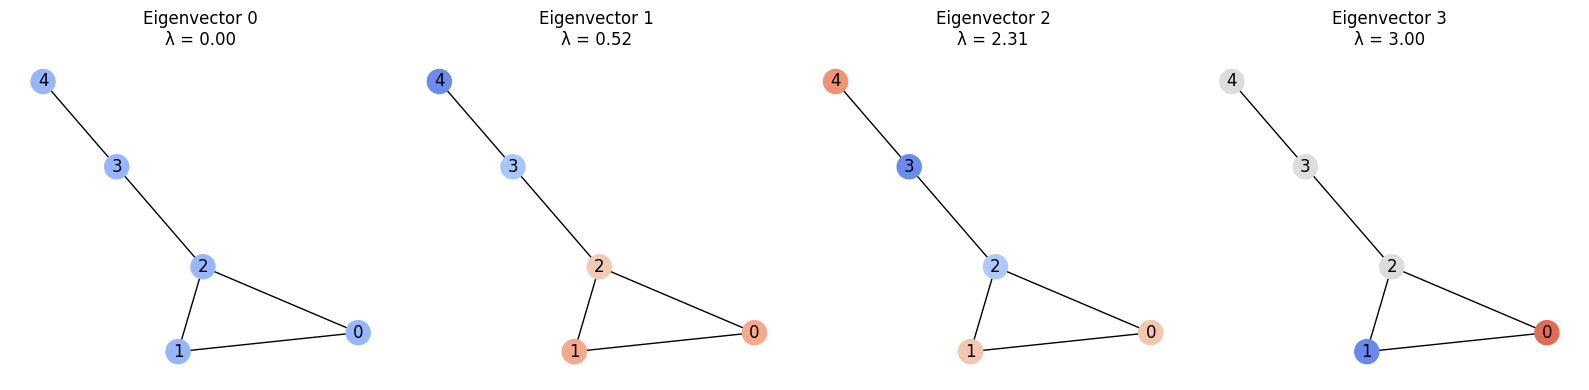

In [111]:
graph = build_example_graph()
plot_laplacian_eigenvectors(graph, num_vecs=4)

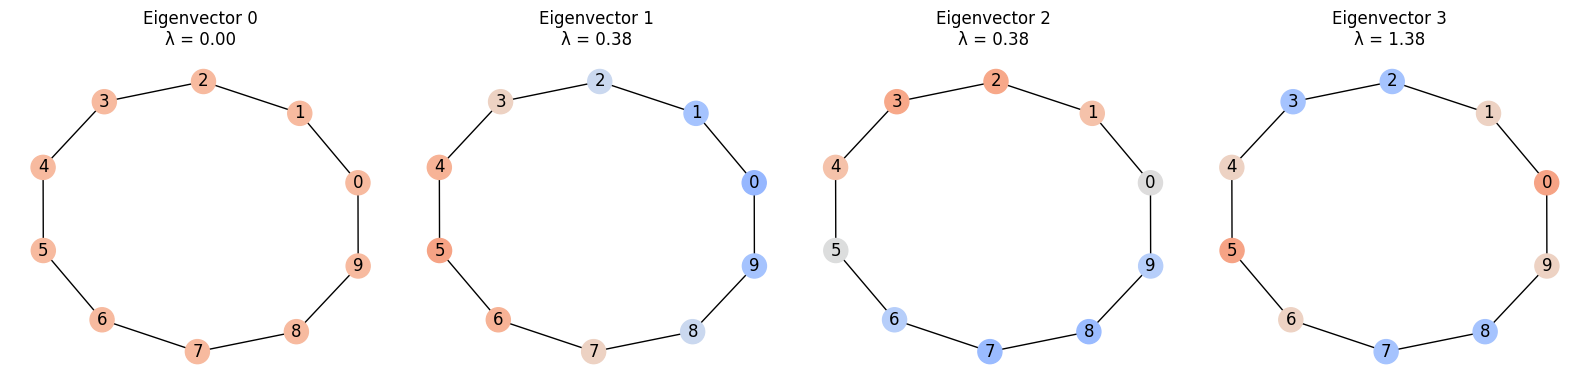

In [112]:
graph = build_circle_graph(10)
plot_laplacian_eigenvectors(graph, num_vecs=4)

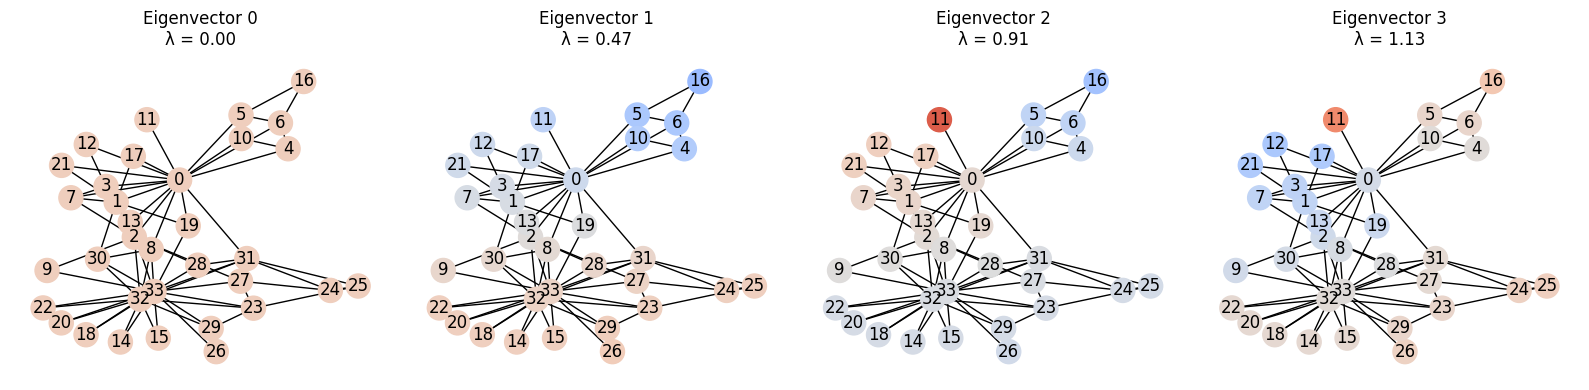

In [113]:
graph = build_karate_graph()
plot_laplacian_eigenvectors(graph, num_vecs=4)

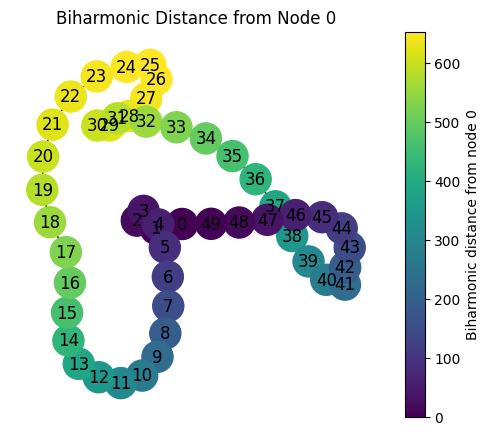

In [114]:
graph = build_circle_graph(50)
plot_biharmonic_distance(graph, source_node=0)

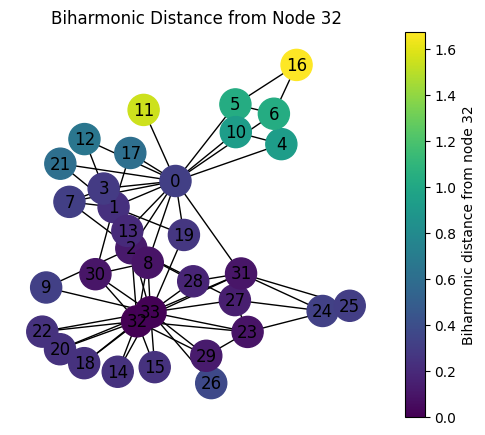

In [115]:
graph = build_karate_graph()
plot_biharmonic_distance(graph, source_node=32)

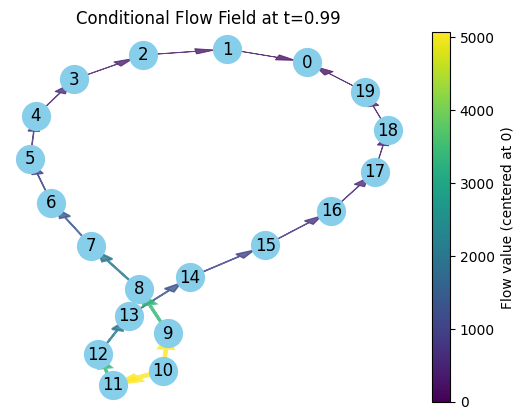

In [116]:
g = build_circle_graph(20)
rho = BiharmonicDistance(g)
t = 0.99
flow = conditional_flow_field(tau=0, rho=rho, t=t, g=g)
plot_edge_flow(g, flow, title=f"Conditional Flow Field at {t=}")

In [130]:
graph = build_circle_graph(10)
tau = 5  # Target node

# Initial uniform distribution over nodes
p0 = uniform_distribution(graph)

# Biharmonic metric and conditional vector field
rho = BiharmonicDistance(graph)
nu_fn = lambda t: conditional_flow_field(tau, rho, t, g=graph)

# Simulate and collect all intermediate states
trajectory = simulate_continuity_equation(p0, nu_fn, num_steps=100, g=graph)

# Extract final state
p_final = trajectory[-1]

# Print or plot result
print("Final distribution coefficients:", p_final)


rho_tau = rho.distance_to(tau)
distances = torch.vstack([torch.inner(rho_tau, c) for c in trajectory])

Final distribution coefficients: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2803e-04, 9.9854e-01,
        7.2803e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00])


(0.0, 2.0)

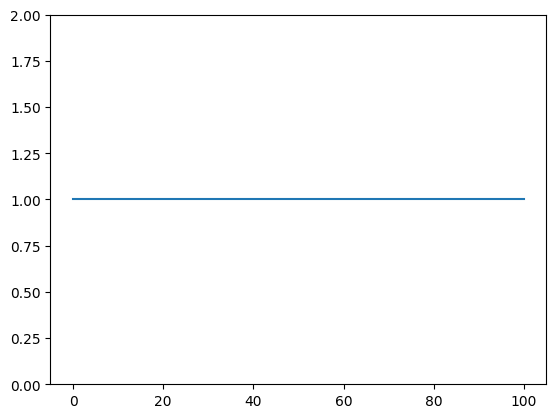

In [131]:
plt.plot(torch.sum(trajectory, dim=1))
plt.ylim(0, 2)

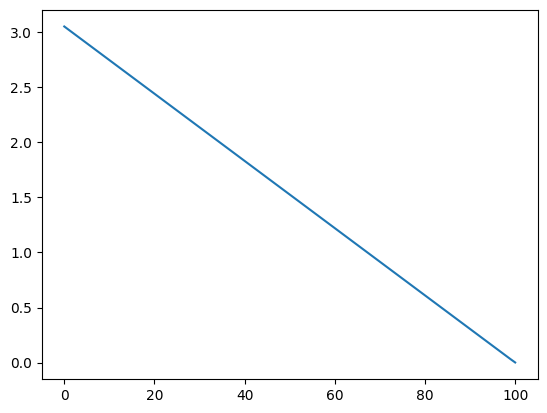

In [132]:
plt.plot(distances)

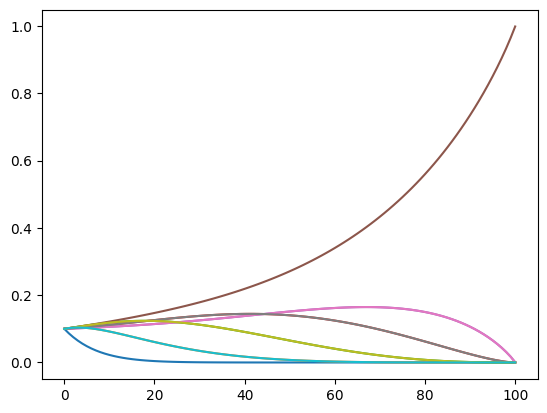

In [133]:
plt.plot(trajectory);

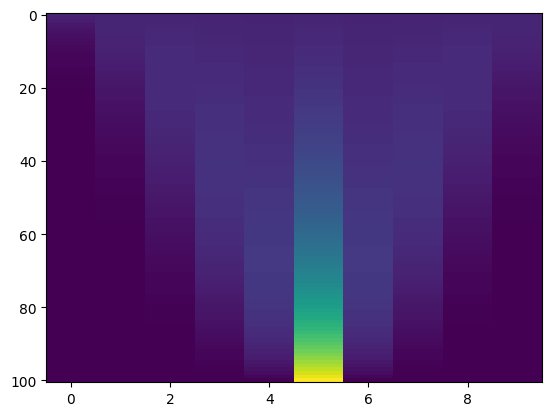

In [134]:
plt.imshow(trajectory, aspect='auto', cmap='viridis')